# Variational Autoencoder

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.stats import norm

import keras
from keras import backend as k
k.clear_session()

Using TensorFlow backend.


In [2]:
# Set Parameter
image_shape = (28,28,1)
batch_size = 64
latent_dim = 10
epoch = 30

In [3]:
# Import MNIST dataset
(x_train, y_train), (x_test,y_test) = keras.datasets.mnist.load_data()

In [4]:
# Change datatype and reshape data
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + image_shape)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + image_shape)

In [5]:
# This function will give us 10 labelled handwritten images from 0-9 
def get_10_image(x_train,y_train):
    selected_x,selected_y = [],[]
    for i in range(10):
        number_index = np.where(y_train == i)[0]
        random_index = np.random.choice(len(number_index),1,replace=False)
        select_index = number_index[random_index]
        selected_x.append(x_train[select_index[0]])
        selected_y.append(y_train[select_index][0])
    return np.array(selected_x,dtype="float32").reshape((len(selected_x),)+image_shape),np.array(selected_y,dtype="float32")

In [6]:
selected_x,selected_y =  get_10_image(x_train,y_train)

In [7]:
print(selected_x.shape) # 10 images of 28 x 28
print(selected_y.shape) # 10 labels for each corresponding image

(10, 28, 28, 1)
(10,)


In [8]:
def plot_image(selected_x,selected_y,title=None,save=None):
    ncols = selected_x.shape[0]
    fig,ax  = plt.subplots(nrows=1, ncols=ncols,figsize=(20,3))
    for x,y,ax_i in zip(selected_x,selected_y,ax):
        ax_i.imshow(x.reshape((28,28)))
        ax_i.axis("off")
        ax_i.set_title(int(y))
    if title:
        fig.suptitle(title)
    if save:
        fig.savefig(str(save)+".png")
    plt.show()

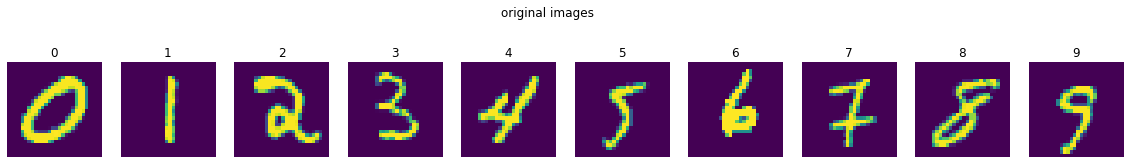

In [9]:
plot_image(selected_x,selected_y,title="original images",save="original_images")

## Encoder

In [10]:
# input shape = (None,28,28,1)
encoder_input = keras.Input(shape=image_shape)

# input shape = (None,28,28,1)
# output shape = (None,28,28,32)
conv_1 = keras.layers.Conv2D(filters=32,
                             kernel_size=3,
                             padding="same",
                             activation="relu",
                            )(encoder_input)

# input shape = (None,28,28,32)
# output shape = (None,28,28,64)
conv_2 = keras.layers.Conv2D(filters=64,
                             kernel_size=3,
                             padding="same",
                             activation="relu",
                            )(conv_1)

# input shape = (None,28,28,64)
# output shape = (None,28,28,64)
conv_3 = keras.layers.Conv2D(filters=64,
                             kernel_size=3,
                             padding="same",
                             activation="relu",
                            )(conv_2)

# input shape = (None,28,28,64)
# output shape = (None,50176)
flatten = keras.layers.Flatten()(conv_3)

# input shape = (None,50176)
# output shape = (None,128)
encoder_output = keras.layers.Dense(128,activation="relu")(flatten)

2023-01-11 13:00:42.315790: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 13:00:42.316155: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


## Latent Space 

In [11]:
# input shape = (None,128)
# output shape = (None,latent_dim)
z_mu = keras.layers.Dense(latent_dim)(encoder_output)

# input shape = (None,128)
# output shape = (None,latent_dim)
z_log_sigma = keras.layers.Dense(latent_dim)(encoder_output)

In [12]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = k.random_normal(shape=(k.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + k.exp(z_log_sigma) * epsilon

In [13]:
z = keras.layers.Lambda(sampling,output_shape=(latent_dim,))([z_mu, z_log_sigma])